[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/lucassiro/mvp_machine_learning/blob/main/mvp_machine_learning_e_analytics.ipynb)

# MVP - Machine Learning & Analytics
### Aluno: Lucas Siqueira Rodrigues

* A ideia principal desse MVP é criar um modelo de classificação de imagens usando redes neuras convolucionais com o framework [PyTorch](https://pytorch.org/) e o dataset [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html).
* O dataset CIFAR-10 contém 60000 imagens, sendo 50000 para treinamento e 10000 para teste, divididas em 10 classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck').

## 1. Importando as bibliotecas

In [1]:
import gdown
import zipfile
import time
import pandas as pd
from torchvision import datasets, transforms
import torch
from torch import nn, flatten
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
import numpy as np
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import itertools
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

## 2. Definindo seeds

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## 3. Baixando o Dataset
Primeiramente, temos que fazer o download do dataset, ele está compactado no google drive, então primeiro iremos baixar usando o gdown, e depois iremos descompactar usando zipfile.

In [3]:
url = 'https://drive.google.com/file/d/1NkmOtxeaH_lMlaMgwCQUw3e_1VoV4FNZ/view?usp=drive_link'
output_path = 'cifar10.zip'
gdown.download(url, output_path, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1NkmOtxeaH_lMlaMgwCQUw3e_1VoV4FNZ
From (redirected): https://drive.google.com/uc?id=1NkmOtxeaH_lMlaMgwCQUw3e_1VoV4FNZ&confirm=t&uuid=197ceb81-27e2-41d9-adaa-c2a119fdb2d8
To: /content/cifar10.zip
100%|██████████| 149M/149M [00:01<00:00, 141MB/s]


'cifar10.zip'

In [4]:
with zipfile.ZipFile('cifar10.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

## 4. Carregando o Dataset
Os arquivos e pastas do dataset estão estruturados da seguinte forma:
```

cifar10
   |--train
   |    |--airplane
   |    |    |-- *.png
   |    |--automobile
   |    |    |-- *.png
        .
        .
        .
   |--test
   |    |--airplane
   |    |    |-- *.png
   |    |--automobile
   |    |    |-- *.png
        .
        .
        .
```

Aqui é definido o transform, que vai realizar algumas operações nas imagens.

In [5]:
mean = 0.5
sd = 0.5

transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((mean,), (sd,)),
    ]
)

Carregando o dataset a partir do caminho, e aplicando o transform.  
Aqui eu passo a pasta contendo as imagens e crio o dataset, as imagens na pasta `cifar10/train/` serão divididas em treino e validação.

In [6]:
dataset_path = "cifar10/train/"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

In [7]:
dataset

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: cifar10/train/
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [8]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Agora iremos dividir o nosso dataset em treino e validação.

In [9]:
train, val = torch.utils.data.random_split(dataset, [45000, 5000])

E finalmente criar os DataLoaders, que são generators, onde as imagens são carregadas na memória a cada iteração, dessa forma permitindo que possamos usar datasets pesados sem a necessidade de usar toda a memória (pois carregamos apenas um pedaço do dataset por vez).

In [10]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True)

In [11]:
train_images, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_images.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 32, 32])
Labels batch shape: torch.Size([32])


Imprimindo alguns exemplos de imagens no dataset.

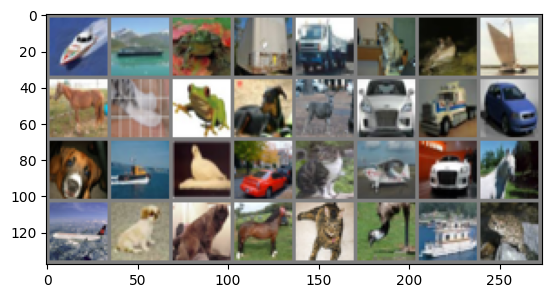

In [12]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print images
imshow(torchvision.utils.make_grid(train_images))

In [13]:
classes = train_dataloader.dataset.dataset.classes
batch_size = 32
print(' '.join(f'{classes[train_labels[j]]:5s}' for j in range(batch_size)))

ship  ship  frog  truck truck cat   frog  ship  horse cat   frog  dog   deer  automobile truck automobile dog   ship  bird  automobile cat   airplane automobile horse airplane dog   dog   horse cat   bird  ship  frog 


In [14]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


# ⚠️ ATENÇÃO ⚠️
Nas seções 5, 6 e 7 o modelo é criado e treinado, se não quiser treinar, pule para a seção 8, onde é realizada a avaliação.  
Usando uma sessão com GPU T4 no Colab, o modelo treinou por 25 épocas em 11 minutos e 50 segundos.

## 5. Definindo o modelo
Para esse projeto, vou usar uma [LeNet5](https://paperswithcode.com/method/lenet).

In [15]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = flatten(x, 1)
        logit = self.classifier(x)
        return logit

In [16]:
model = LeNet5(num_classes=10)
model.to(device)
model

LeNet5(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

## 6. Definindo funções para treinar o modelo

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [18]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

# 7. Treinando e salvando o modelo
Aqui, realizo o treino do modelo.
Após alguns experimentos eu optei por treinar por 25 épocas, após isso acredito que o modelo poderia começar a overfitar.

In [19]:
%%time
results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=25,
    device=device
)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0539 | train_acc: 0.2474 | test_loss: 1.9072 | test_acc: 0.3008
Epoch: 2 | train_loss: 1.7616 | train_acc: 0.3666 | test_loss: 1.6516 | test_acc: 0.4015
Epoch: 3 | train_loss: 1.5955 | train_acc: 0.4227 | test_loss: 1.5406 | test_acc: 0.4425
Epoch: 4 | train_loss: 1.4964 | train_acc: 0.4544 | test_loss: 1.4447 | test_acc: 0.4865
Epoch: 5 | train_loss: 1.4108 | train_acc: 0.4875 | test_loss: 1.3899 | test_acc: 0.5102
Epoch: 6 | train_loss: 1.3496 | train_acc: 0.5111 | test_loss: 1.3273 | test_acc: 0.5243
Epoch: 7 | train_loss: 1.2986 | train_acc: 0.5339 | test_loss: 1.3019 | test_acc: 0.5414
Epoch: 8 | train_loss: 1.2538 | train_acc: 0.5512 | test_loss: 1.2623 | test_acc: 0.5529
Epoch: 9 | train_loss: 1.2120 | train_acc: 0.5668 | test_loss: 1.2063 | test_acc: 0.5699
Epoch: 10 | train_loss: 1.1753 | train_acc: 0.5823 | test_loss: 1.1936 | test_acc: 0.5816
Epoch: 11 | train_loss: 1.1448 | train_acc: 0.5928 | test_loss: 1.1444 | test_acc: 0.6021
Epoch: 12 | train_l

In [30]:
path = "lenet_cifar10.pt"
torch.save(model, path)

<Axes: >

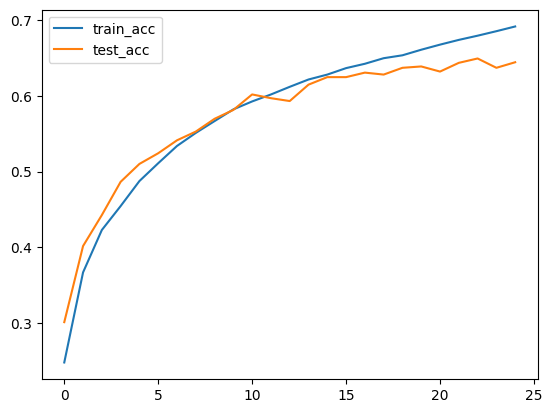

In [31]:
# plotando os resultados
pd.DataFrame(results)[["train_acc", "test_acc"]].plot()

<Axes: >

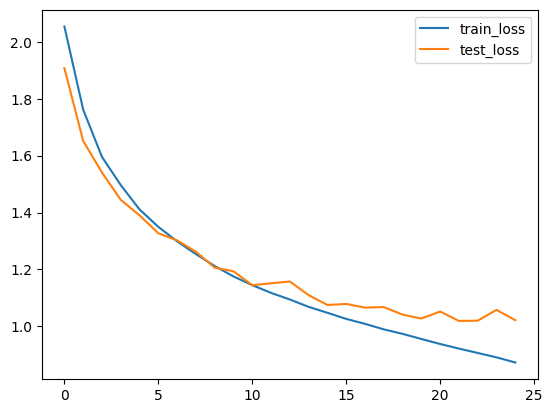

In [32]:
pd.DataFrame(results)[["train_loss", "test_loss"]].plot()

# 8. Avaliando o modelo

Carregando o modelo.

In [33]:
path = "lenet_cifar10.pt"
model = torch.load(path)
model.eval() # colocando o modelo em modo de avaliação
model.to(device)

LeNet5(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

Computando a quantidade de parâmetros do modelo.

In [44]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_parameters(model)
print(f"O modelo possui {params} parâmetros.")

O modelo possui 62006 parâmetros.


Carregando o dataset de test que está no caminho `cifar10/test/`.

In [34]:
test_dataset_path = "cifar10/test/"
test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [35]:
%%time
labels = list()
predicted_labels = list()

for images_batch, labels_batch in tqdm(test_dataloader):
    with torch.inference_mode():
        predictions = model(images_batch.to(device))
        predicted_labels.extend(predictions)
        labels.extend(labels_batch)

  0%|          | 0/313 [00:00<?, ?it/s]

CPU times: user 5.5 s, sys: 318 ms, total: 5.81 s
Wall time: 6.25 s


In [36]:
predicted_labels = [int(np.argmax(i.cpu())) for i in predicted_labels]
labels = [int(i) for i in labels]

In [37]:
def make_confusion_matrix(
    y_true,
    y_pred,
    classes=None,
    figsize=(10, 10),
    text_size=15,
    title="Confusion Matrix",
):
    cm = confusion_matrix(y_true, y_pred).round(2)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    n_classes = cm.shape[0]

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(
        cm_norm, cmap="Blues"
    )  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(
        title=title,
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),  # create enough axis slots for each class
        yticks=np.arange(n_classes),
        # axes will labeled with class names (if they exist) or ints
        xticklabels=labels,
        yticklabels=labels,
    )

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.0

    # Plot the text on each cell
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(
            x=j,
            y=i,
            s=f"{cm_norm[i, j]:.2f}\n({cm[i, j]})",
            horizontalalignment="center",
            verticalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size,
        )

Gerando a matriz de confusão com os resultados, essa matriz de confusão possui os valores relativos em cima e os absolutos em baixo (dentro dos parênteses).

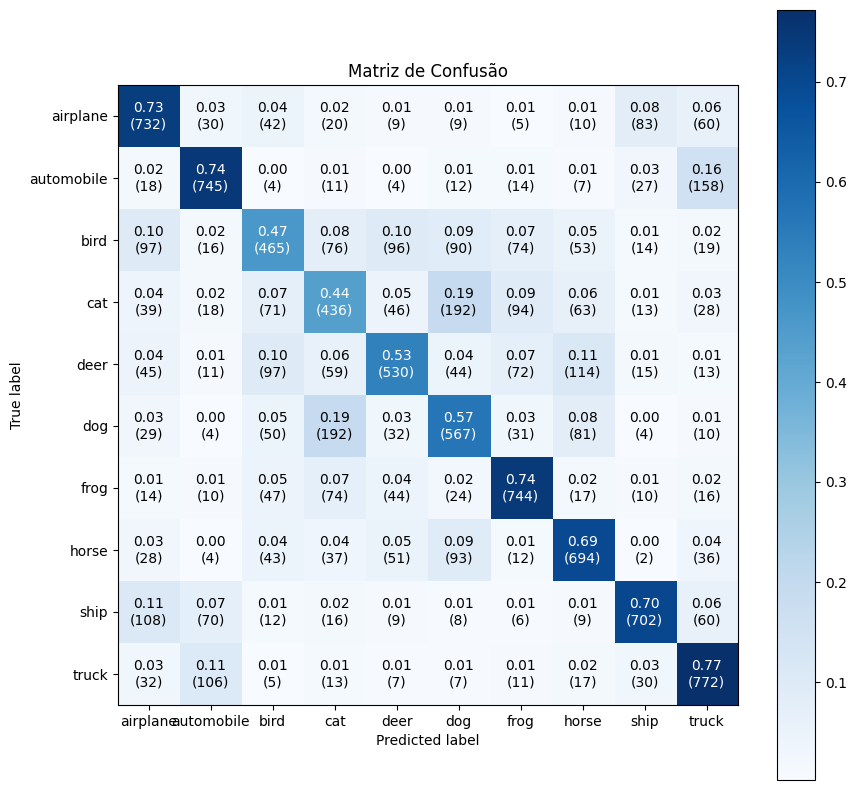

In [45]:
make_confusion_matrix(
    y_true=labels,
    y_pred=predicted_labels,
    classes=classes,
    figsize=(10, 10),
    text_size=10,
    title="Matriz de Confusão",
)

In [39]:
acc = accuracy_score(y_true=labels, y_pred=predicted_labels)

print(f"Accuracy: {acc}")

Accuracy: 0.6387


# 9. Conclusões

* Acurácia do conjunto de teste ficou em 63,87%, que considero uma acurácia boa, considerando que são 10 classes, que as imagens estão em baixa resolução (32x32 pixels) e que a arquitetura (LeNet) usada é uma arquitetura bem simples que possui apenas 62.006 parâmetros (que é um número bem pequeno quando se compara a outras arquiteturas que possuem milhões de parâmetros).
* O PyTorch é um excelente framework, possui uma comunidade grande e excelente documentação.
* O modelo foi treinado por 25 épocas, os valores de acurácia e loss de teste ainda poderia melhorar um pouco, mas como ele estavam oscilando bastante, seria um pouco difícil de identificar quando o modelo estivesse começando a overfitar, e por isso optei por treinar por apenas 25 épocas.
* Para problemas como a de classificação de imagens, acredito que podemos obter uma acurácia bem melhor com algumas melhorias, como usar outras arquiteturas mais robustas (como a ResNet50, MobileNet, EfficientNet), principalmente usando transferência de aprendizagem (que por não ter sido abordado nessa disciplina, optei por não usar nesse MVP).
* No geral, acredito que o resultado foi bom, e a acurácia com a matriz de confusão conseguem nos informar bastante sobre como o modelo esta performando.